In [1]:
import torch
import numpy as np
import sepgroupy.gconv as sepGroupConv
import matplotlib.pyplot as plt
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4
import torch.nn as nn
from sepgroupy.gconv import GroupMaxPool2d, GroupCosetMaxPool
from groupblurpool import GroupMaxBlurPool2d
import cv2
import time
from datetime import timedelta
import torch.optim as optim
from torchinfo import summary
from PIL import Image
from torchvision.transforms.functional import resize
from scipy.ndimage.filters import gaussian_filter
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True

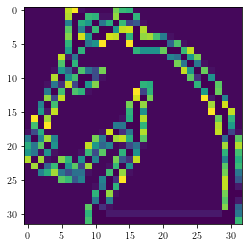

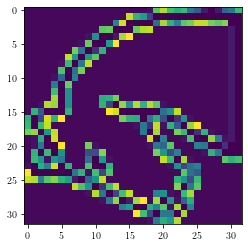

In [2]:
knight = np.asarray(Image.open("./knight.png"))
k = knight.copy()
k.setflags(write=1)
for i in range(knight.shape[0]):
    for j in range(knight.shape[1]):
        if knight[i][j]  == 0:
            k[i][j] = 255
        elif knight[i][j] == 1:
            k[i][j] = 0
        else:
            k[i][j] = 6 * knight[i][j]
k = gaussian_filter(k, sigma=0.25)
plt.imshow(knight)
plt.show()
knight90 = np.rot90(knight, k=1)
plt.imshow(knight90)
plt.show()

In [3]:
batch_inp = torch.Tensor([[knight], [knight90]])
labels = torch.tensor([0, 1], dtype=torch.long)
print(batch_inp.shape)

torch.Size([2, 1, 32, 32])


In [4]:
def train(model, epochs=100, printerval=10, lr=0.0001, mom=0.9, item=batch_inp):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)

    start_time = time.time()
    print("Started at: " + time.strftime("%H:%M:%S", time.localtime()))
    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(item)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if epoch % printerval == 0:    # print every 2000 mini-batches
            print(f'Epoch {epoch} - Loss = {loss.item()}')
            model.show_filter(save=f'./epoch{epoch}_square.png')

    print('Finished Training')
    elapsed_time = time.time() - start_time
    print('Finished Training in: ' + str(timedelta(seconds=elapsed_time))) 

In [5]:
class CustomNet(nn.Module):
    def __init__(self, stride=2, kernel_size=3, channels=1):
        super().__init__()
        self.net = nn.Sequential(P4ConvZ2(1, channels, kernel_size, stride=stride, padding=1),)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.gcmp = GroupCosetMaxPool()
        self.fc = nn.Linear(channels, 2)
        self.len = len(self.net)
    
    def forward(self, x):
        x = self.net(x)
        s = x.shape
        x = x.view((s[0], s[1] * s[2], s[3], s[4]))
        x = self.avgpool(x)

        x = x.view((s[0], s[1], s[2], 1, 1))
        x = self.gcmp(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x
    
    def get_featuremap(self, x, i, pr=False):
        net = self.net[:i]
        if pr:
            print(self.net[(i-1)])
        return net(x)
    
    def show_filter(self, inp1=torch.Tensor([knight]), inp2=torch.Tensor([knight90]), save=None):
        f = self.net[0].weight.data[0, 0, 0, :, :]
        
        fig, axs = plt.subplots(2,2)
        #plt.tight_layout(h_pad=-2)
        axs[0, 0].set_title('$x$')
        axs[0, 0].set_xticks([]); axs[0, 0].set_yticks([])
        axs[0, 0].imshow(knight, cmap='Greys')
        
        axs[1, 0].set_title('Filter')
        axs[1, 0].set_xticks([]); axs[0, 1].set_yticks([])
        axs[1, 0].imshow(f, cmap='Greys')

        summed_fm = torch.sum(self.net(inp1)[0, 0], dim=0).detach().numpy()
        axs[0, 1].imshow(summed_fm, cmap='Greys')
        axs[0, 1].set_xticks([]); axs[1, 0].set_yticks([])
        axs[0, 1].set_title('$f(x)$')
        
        summed_fm2 = np.rot90(torch.sum(self.net(inp2)[0, 0], dim=0).detach().numpy(), k=3)
        axs[1, 1].imshow(summed_fm2, cmap='Greys')
        axs[1, 1].set_xticks([]); axs[1, 1].set_yticks([])
        axs[1, 1].set_title('$T^{-1}(f(T(x)))$')
        plt.subplots_adjust(left=0.3, bottom=0.1)
        if save is not None:
            plt.savefig(save, dpi=400, bbox_inches='tight')
        plt.show()
    
    def show_featuremap(self, inp):
        summed_fm = torch.sum(self.net(inp)[0, 0], dim=0).detach().numpy()
        plt.imshow(summed_fm)
        plt.show()

INPUT SHAPE torch.Size([2, 1, 32, 32])
Layer (type:depth-idx)                   Output Shape              Param #
CustomNet                                --                        --
├─Sequential: 1-1                        [2, 1, 4, 16, 16]         --
│    └─P4ConvZ2: 2-1                     [2, 1, 4, 16, 16]         10
├─AdaptiveAvgPool2d: 1-2                 [2, 4, 1, 1]              --
├─GroupCosetMaxPool: 1-3                 [2, 1, 1, 1]              --
├─Linear: 1-4                            [2, 2]                    4
Total params: 14
Trainable params: 14
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
Started at: 12:05:39
Epoch 0 - Loss = 0.7004213333129883


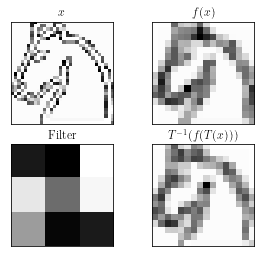

Epoch 100 - Loss = 0.6833577156066895


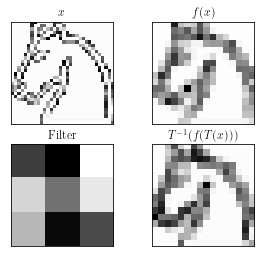

Epoch 200 - Loss = 0.6185940504074097


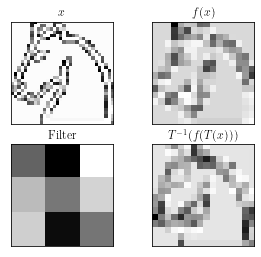

Epoch 300 - Loss = 0.3175642490386963


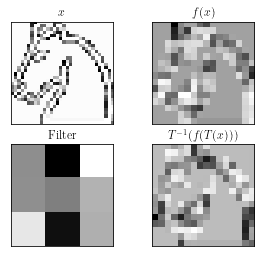

Epoch 400 - Loss = 0.09234318137168884


In [ ]:
SAMPLE = batch_inp
model = CustomNet(stride=2, kernel_size=3, channels=1)
print(f'INPUT SHAPE {SAMPLE.shape}')
print(summary(model, SAMPLE.shape))
train(model, 800, printerval=100, lr=0.001, mom=0.9, item=SAMPLE)